In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import nivapy3 as nivapy
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use("ggplot")

# QC of sensor data

There is NIVA sensor data for 2023 for Glomma. Aim in this notebook is to do a quick manual QC of this data. There are already automated QC procedures in place, but these tend to be too stringent for some parameters, e.g. turbidity which is spiky. Aim in AquaInfra to work with Ivana to improve these QC routines.

Data is from NIVA station 'Baterød', which I think is located adjacent to where the elveovervåking samples are taking (needs checking!). Leah JB downloaded the latest data on 2024-08-28 and it is stored here: aquainfra/data/river/sensors/glomma_sensor_data_raw_2024-08-28.csv

To do:
* Plot the 6 data columns and see whether there are dodgy values
* Work with Ivana to see whether the quality flags that have already been assigned are useful in identifying dodgy values or are too lax/strict
* Come up with new quality flags to remove dodgy data
* Fill any gaps in the data in a sensible way. E.g. linear interpolation if they are short
* Save cleaned high frequency data
* Convert to daily means and save again

In [2]:
# User's input

fpath = r'../../data/river/sensors/glomma_sensor_data_raw_2024-08-28.csv'
qfpath = r'../../data/river/discharge/clean/Q_daily-mean_Glomma_Solbergfoss_2.605.0_cleaned.csv'

out_path_hourly = r'../../data/river/sensors/hourly_glomma_sensor_data_2024-08-28_cleaned_manualy.csv'
out_path_daily = r'../../data/river/sensors/daily_glomma_sensor_data_2024-08-28_cleaned_manualy.csv'

variables = ['CDOMdigitalFinal (µg/L)', 'PhValue_Avg (-)', 'Temp_water_Avg (degC)', 
             'CondValue_Avg (µS/cm)', 'Turbidity_Avg (NTU)', 'Salinity_Avg (-)']

variables_exc_ph = ['CDOMdigitalFinal (µg/L)', 'Temp_water_Avg (degC)', 'CondValue_Avg (µS/cm)', 'Turbidity_Avg (NTU)', 'Salinity_Avg (-)']

variables_flags = [
    ('CDOMdigitalFinal (µg/L)', 'QC flag CDOMdigitalFinal'),
    ('PhValue_Avg (-)', 'QC flag PhValue_Avg'),
    ('Temp_water_Avg (degC)', 'QC flag Temp_water_Avg'),
    ('CondValue_Avg (µS/cm)', 'QC flag CondValue_Avg'),
    ('Turbidity_Avg (NTU)', 'QC flag Turbidity_Avg'),
    ('Salinity_Avg (-)', 'QC flag Salinity_Avg')
]

variables_flags_manual = [
    ('CDOMdigitalFinal (µg/L)', 'CDOMdigitalFinal_outlier_manual'),
    ('PhValue_Avg (-)', 'PhValue_Avg_outlier_manual'),
    ('Temp_water_Avg (degC)', 'Temp_water_Avg_outlier_manual'),
    ('CondValue_Avg (µS/cm)', 'CondValue_Avg_outlier_manual'),
    ('Turbidity_Avg (NTU)', 'Turbidity_Avg_outlier_manual'),
    ('Salinity_Avg (-)', 'Salinity_Avg_outlier_manual')
]

columns_to_drop = ['QC flag CDOMdigitalFinal', 'QC flag PhValue_Avg', 'QC flag Temp_water_Avg', 'QC flag CondValue_Avg', 'QC flag Turbidity_Avg',
                   'QC flag Salinity_Avg', 'Month', 'Color', 'CDOMdigitalFinal_outlier_manual', 'PhValue_Avg_outlier_manual', 'Temp_water_Avg_outlier_manual', 
                   'CondValue_Avg_outlier_manual', 'Turbidity_Avg_outlier_manual', 'Salinity_Avg_outlier_manual']

### 1. Read in file

In [3]:
df = pd.read_csv(fpath, index_col=0, parse_dates=True)

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
df['Month'] = df.index.to_period('M')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13726 entries, 2023-02-02 15:00:00 to 2024-08-27 12:00:00
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Date                      13726 non-null  object   
 1   Time                      13726 non-null  object   
 2   CDOMdigitalFinal (µg/L)   13726 non-null  float64  
 3   QC flag CDOMdigitalFinal  13719 non-null  object   
 4   PhValue_Avg (-)           13724 non-null  float64  
 5   QC flag PhValue_Avg       13717 non-null  object   
 6   Temp_water_Avg (degC)     13725 non-null  float64  
 7   QC flag Temp_water_Avg    13718 non-null  object   
 8   CondValue_Avg (µS/cm)     13725 non-null  float64  
 9   QC flag CondValue_Avg     13718 non-null  object   
 10  Turbidity_Avg (NTU)       13726 non-null  float64  
 11  QC flag Turbidity_Avg     13719 non-null  object   
 12  Salinity_Avg (-)          13725 non-null  float64  
 

### 2. Plot raw data

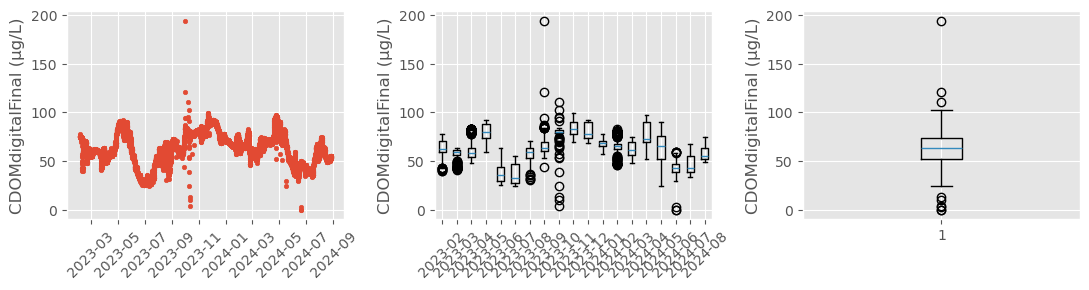

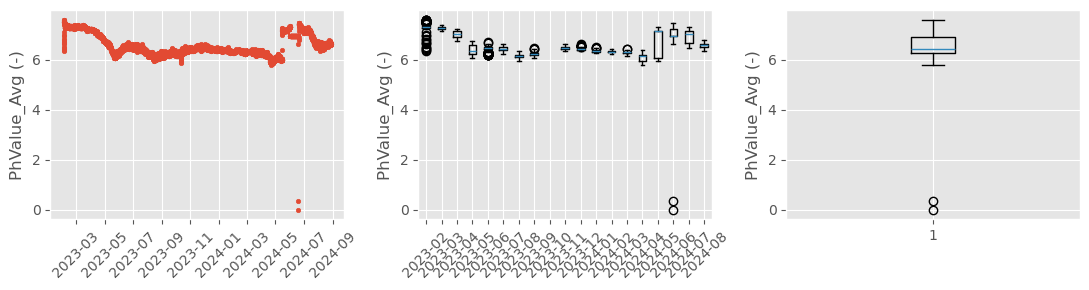

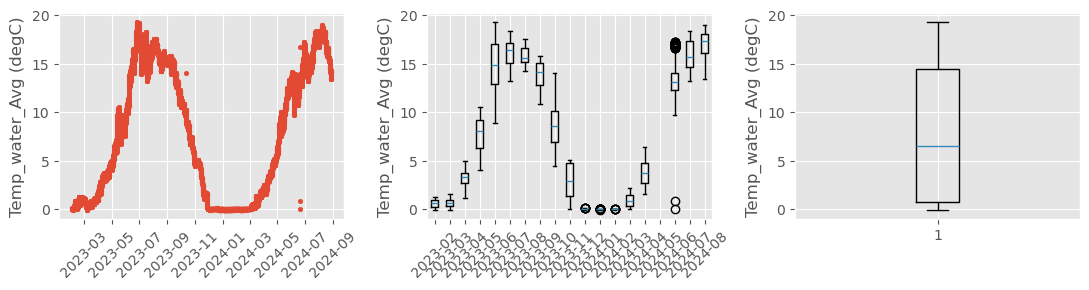

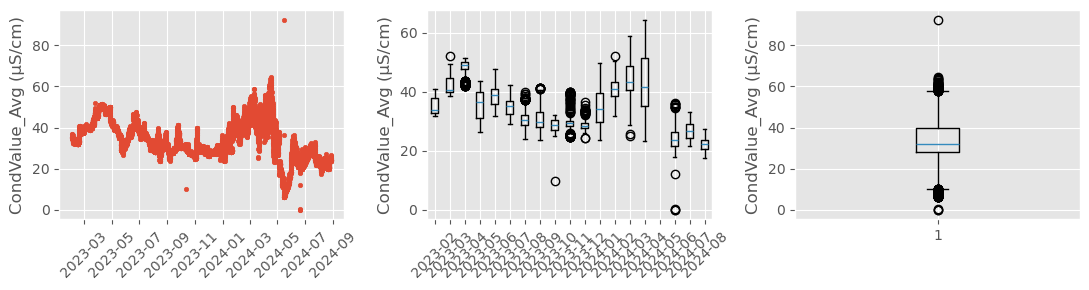

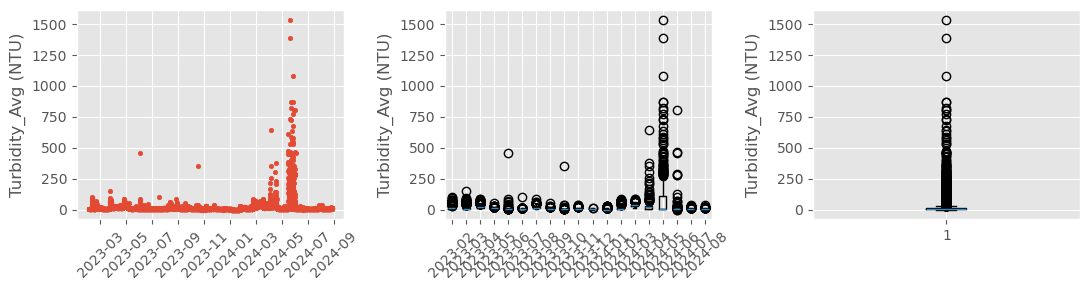

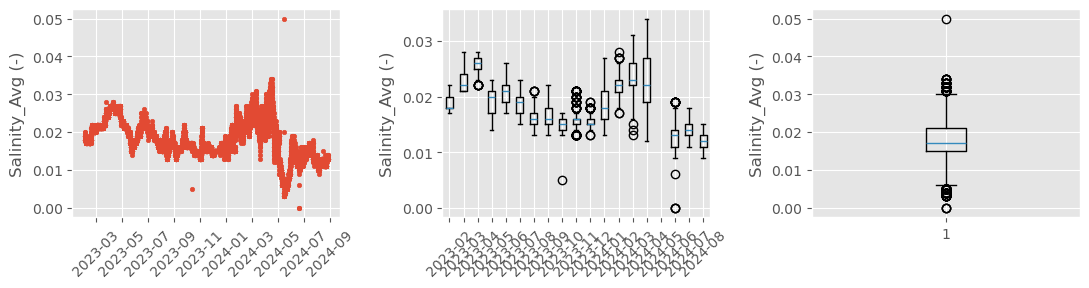

In [4]:
for var in variables:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))

    # Scatter plot
    ax1.scatter(df.index, df[var], s=10)
    ax1.set_ylabel(var)
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Monthly boxplots
    df_monthly = df.groupby('Month')[var].apply(list).reset_index()
    ax2.boxplot(df_monthly[var].dropna(), positions=range(len(df_monthly)))
    ax2.set_ylabel(var)
    ax2.set_xticklabels(df_monthly['Month'].astype(str), rotation=45)

    # Boxplot
    ax3.boxplot(df[var].dropna())
    ax3.set_ylabel(var)

    plt.tight_layout()
    plt.show()


### 3. Plot the raw data with the quality flags that have already been assigned  

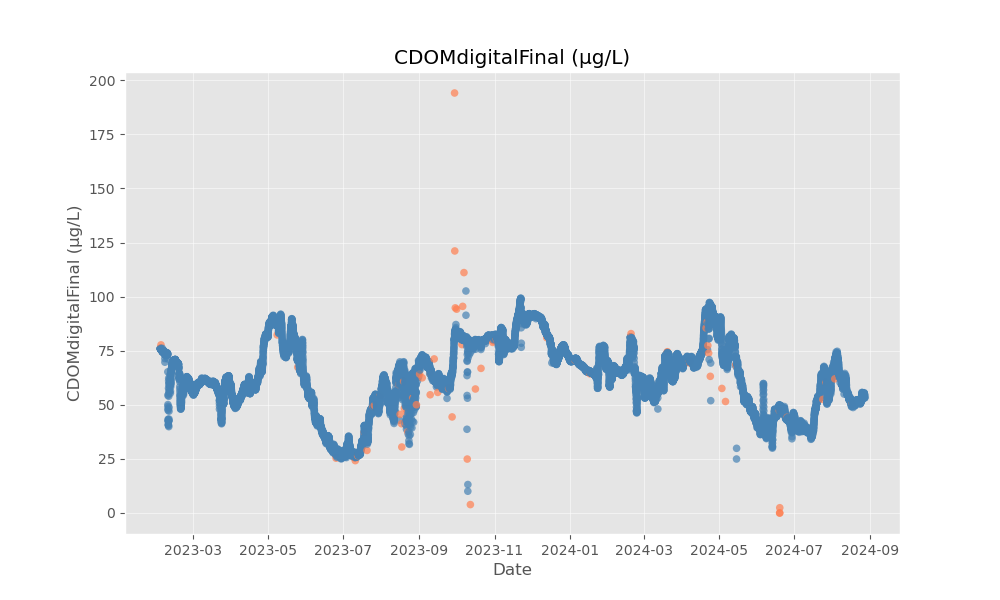

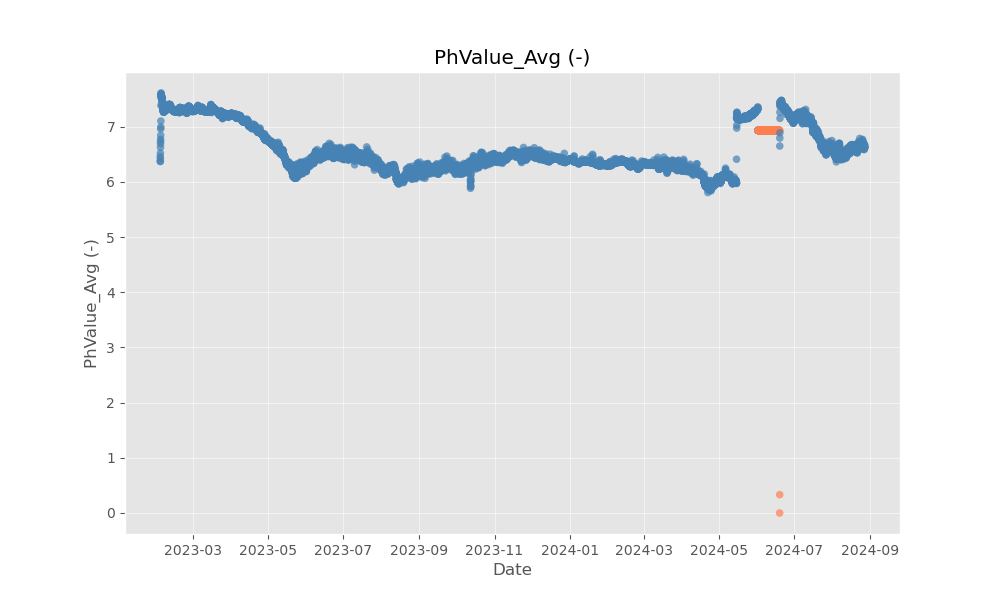

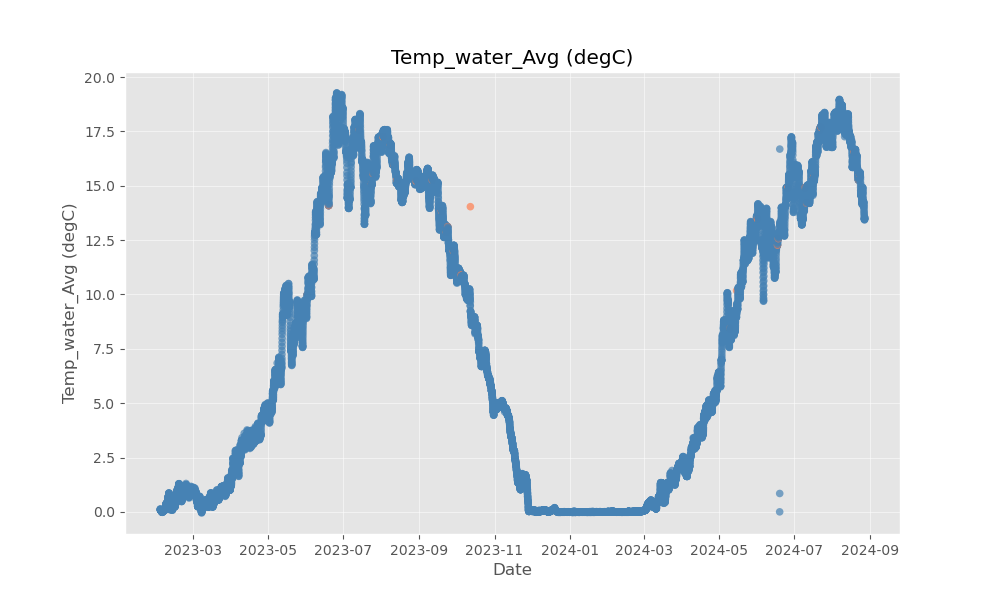

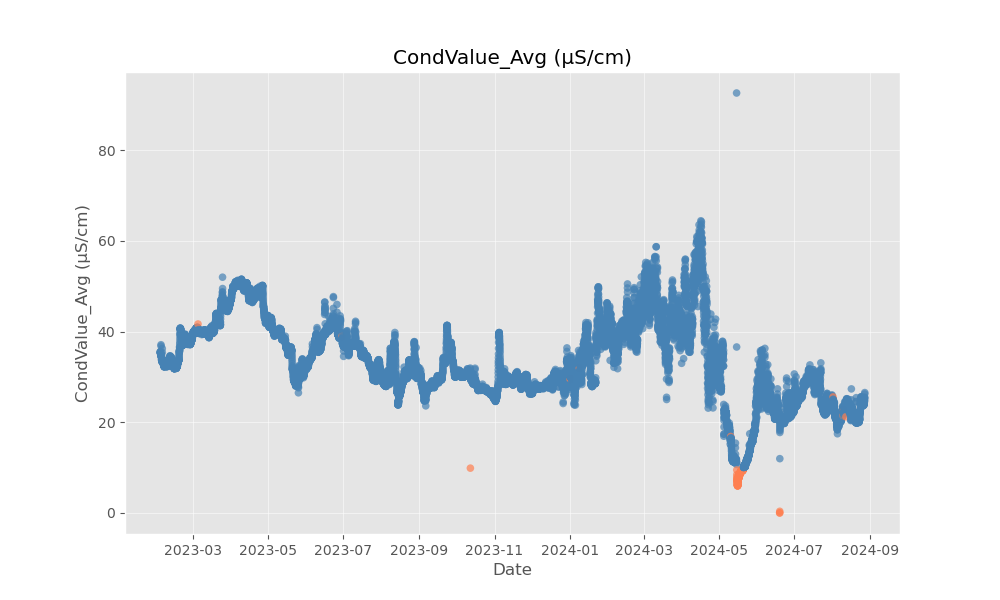

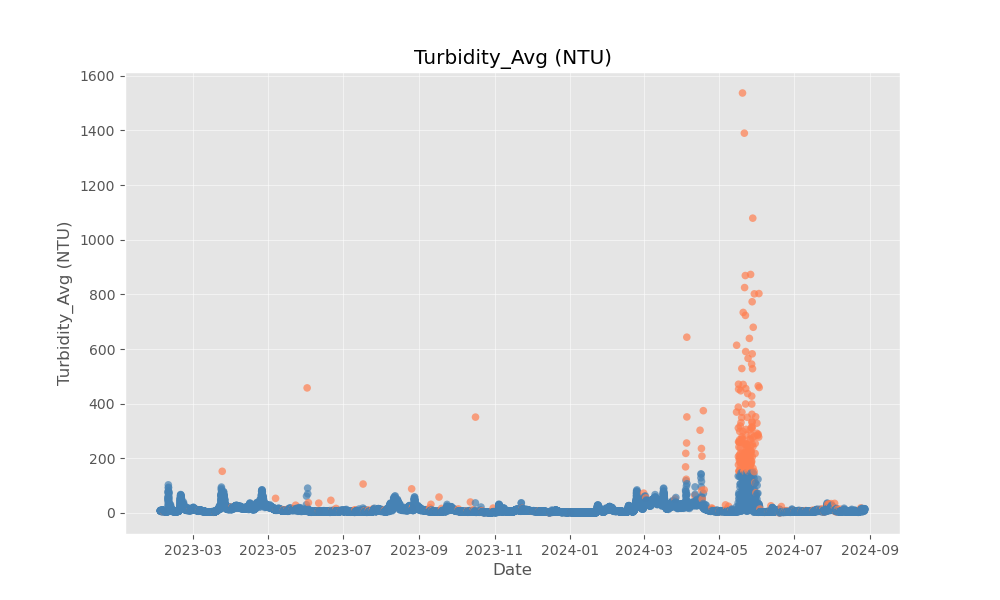

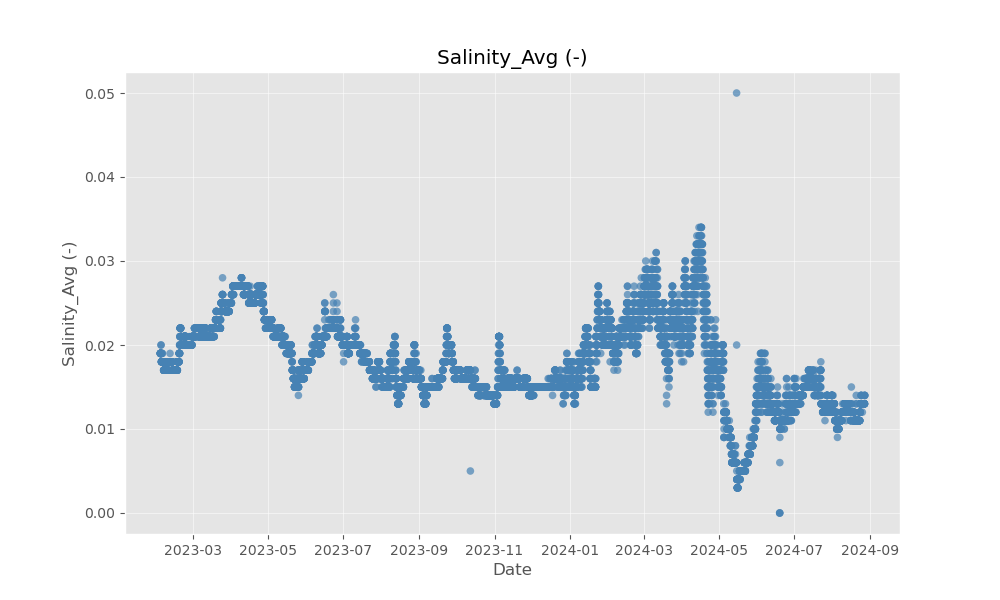

In [5]:
# Interactive plotting
%matplotlib widget

def plot_variable(df, variable, outlier, qc_flag):
    # Create a new column to identify bad values
    df['Color'] = df[qc_flag].apply(lambda x: 'coral' if x == outlier else 'steelblue')
    
    # Plot the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[variable], c=df['Color'], edgecolors='none', alpha=0.7, s=30)
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.title(f'{variable}')
    plt.grid(True, alpha =0.5)
    plt.show()

for variable, qc_flag in variables_flags:
    plot_variable(df, variable, 'Bad', qc_flag)

**Note:** I believe the quality flags currently assigned may be either too lenient or too strict, depending on the variable in question. For instance, no outliers have been flagged for salinity, yet there appear to be potential outliers, such as a value in May 2024 exceeding 0.05. In contrast, all turbidity values for the same period (May 2024) seem reasonable, especially given the low salinity levels indicative of substantial freshwater input during that time.

### 4. Manually specify outlier conditions

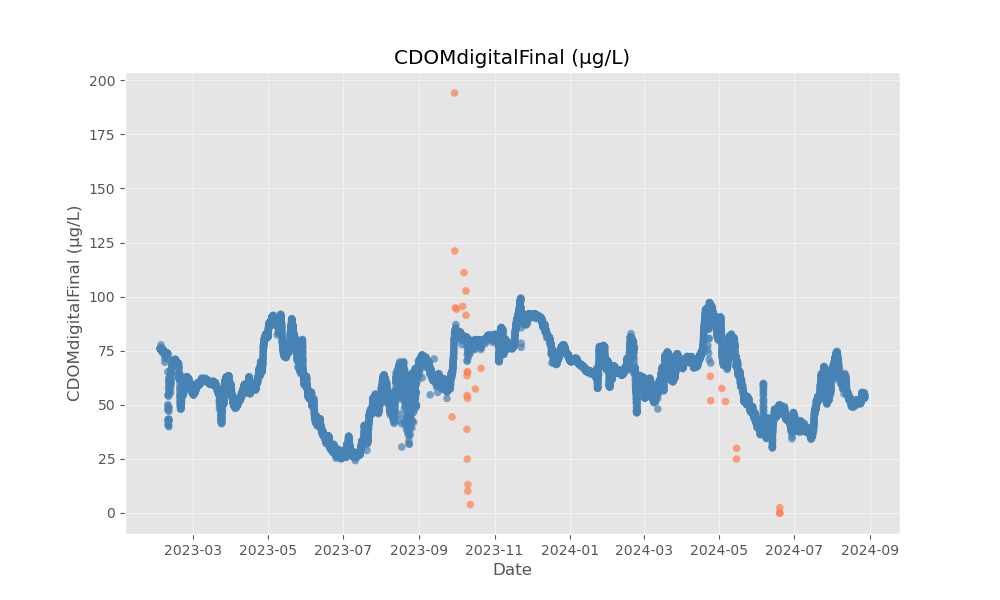

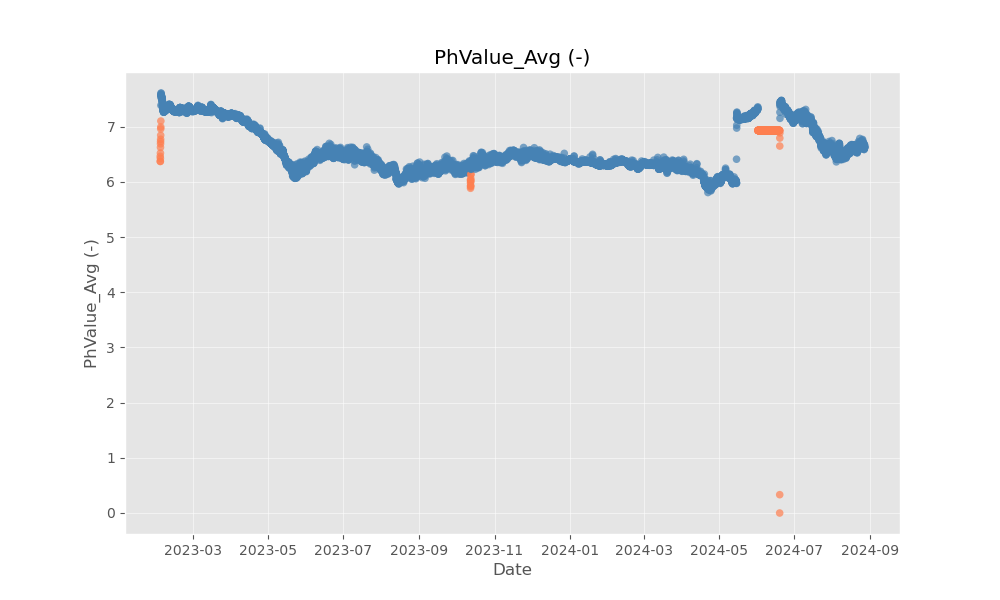

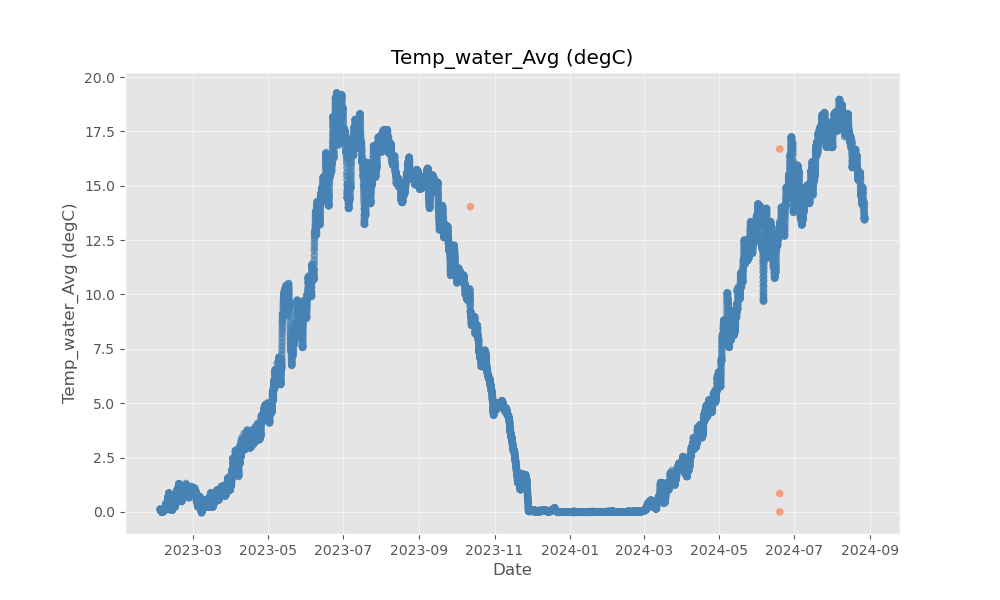

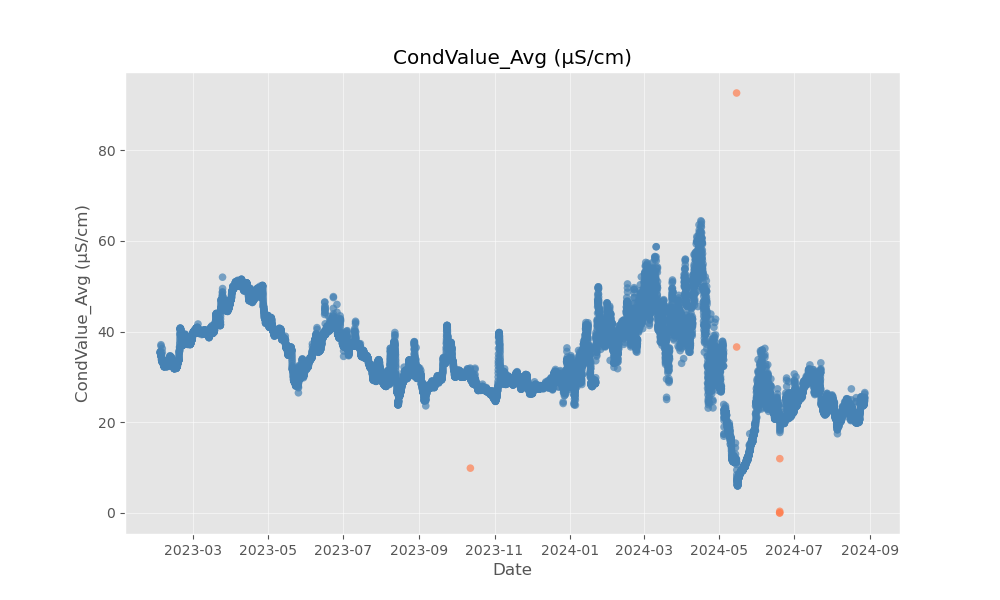

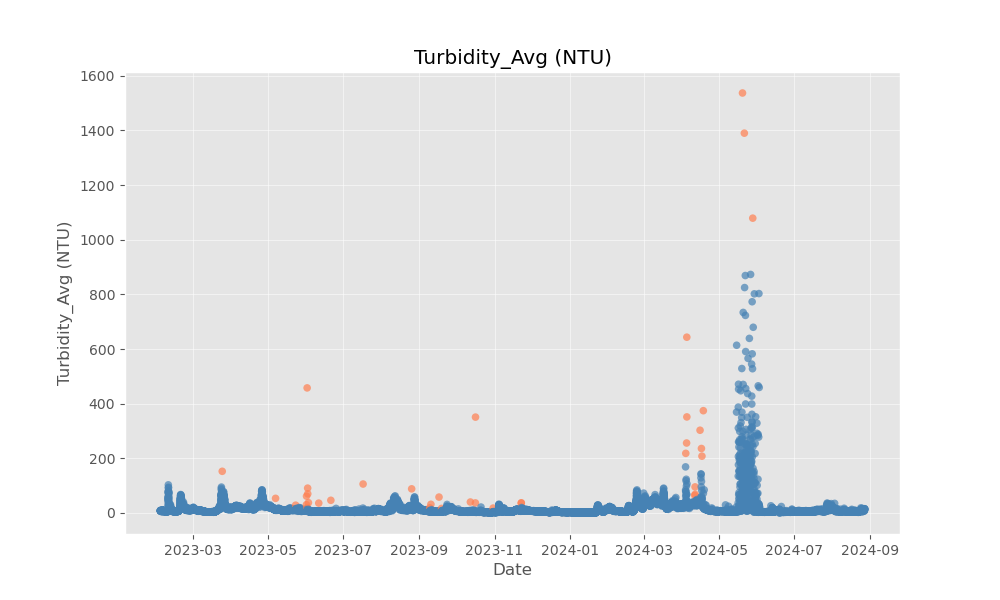

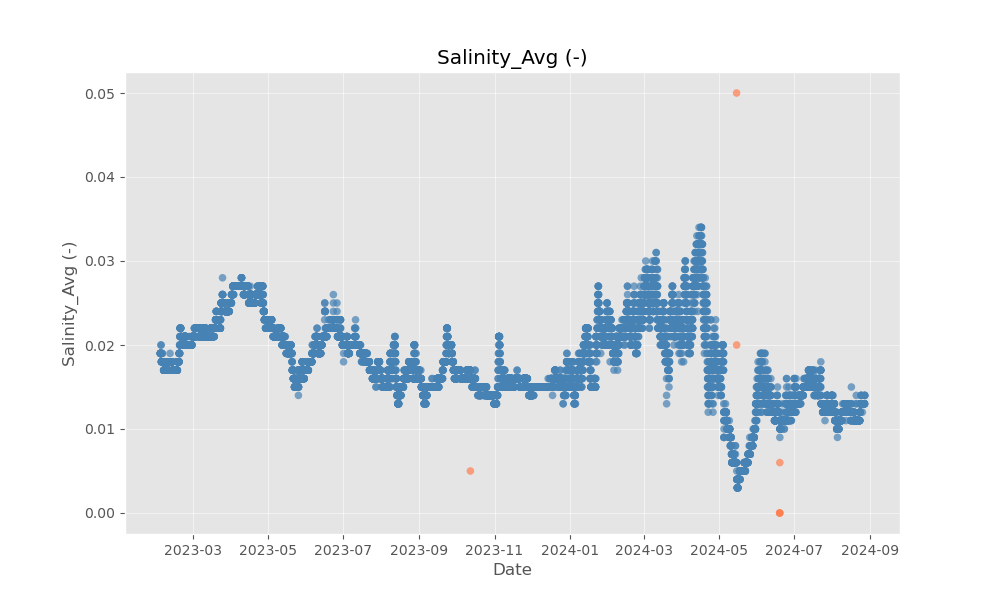

In [6]:
# Define the conditions for outliers
df['Date'] = pd.to_datetime(df['Date'])

def identify_CDOMoutliers(row):
    if row['CDOMdigitalFinal (µg/L)'] > 102 or row['CDOMdigitalFinal (µg/L)'] < 12:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] > 93:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] < 45:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CDOMdigitalFinal (µg/L)'] < 67:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CDOMdigitalFinal (µg/L)'] > 90:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 4 and row['CDOMdigitalFinal (µg/L)'] < 65:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['CDOMdigitalFinal (µg/L)'] < 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-03') and row['CDOMdigitalFinal (µg/L)'] < 58:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-06') and row['CDOMdigitalFinal (µg/L)'] < 53:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 9 and row['CDOMdigitalFinal (µg/L)'] < 63:
        return 1
    return 0

def identify_PHoutliers(row):
    if row['PhValue_Avg (-)'] <1:
        return 1
    if row['Date'] == pd.Timestamp('2023-02-02') and row['PhValue_Avg (-)'] < 7.2:
        return 1
    if row['Date'] == pd.Timestamp('2023-02-03') and row['PhValue_Avg (-)'] < 7.2:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-12') and row['PhValue_Avg (-)'] < 6.2:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 6 and row['PhValue_Avg (-)'] < 7:
        return 1
    return 0

def identify_TEMPoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Temp_water_Avg (degC)'] > 13:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 6 and row['Temp_water_Avg (degC)'] < 2:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['Temp_water_Avg (degC)'] > 15:
        return 1
    return 0
    

def identify_CONDoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['CondValue_Avg (µS/cm)'] < 20:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['CondValue_Avg (µS/cm)'] > 80:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-15') and row['CondValue_Avg (µS/cm)'] > 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['CondValue_Avg (µS/cm)'] < 15:
        return 1
    return 0

def identify_TURBoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 3 and row['Turbidity_Avg (NTU)'] > 140:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 6 and row['Turbidity_Avg (NTU)'] > 300:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Turbidity_Avg (NTU)'] > 200:
        return 1
    if row['Date'] == pd.Timestamp('2023-05-07') and row['Turbidity_Avg (NTU)'] > 50:
        return 1
    if row['Date'] == pd.Timestamp('2023-05-23') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-11') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-21') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-01') and row['Turbidity_Avg (NTU)'] > 18.8:
        return 1
    if row['Date'] == pd.Timestamp('2023-06-02') and row['Turbidity_Avg (NTU)'] > 18.8:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 7 and row['Turbidity_Avg (NTU)'] > 100:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 8 and row['Turbidity_Avg (NTU)'] > 80:
        return 1
    if row['Date'].year == 2023 and row['Date'].month == 9 and row['Turbidity_Avg (NTU)'] > 50:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-09') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-10') and row['Turbidity_Avg (NTU)'] > 20:
        return 1
    if row['Date'] == pd.Timestamp('2023-09-18') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-12') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-16') and row['Turbidity_Avg (NTU)'] > 25:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-20') and row['Turbidity_Avg (NTU)'] > 20:
        return 1
    if row['Date'] == pd.Timestamp('2023-10-30') and row['Turbidity_Avg (NTU)'] > 15:
        return 1
    if row['Date'] == pd.Timestamp('2023-11-22') and row['Turbidity_Avg (NTU)'] > 30:
        return 1
    if row['Date'] == pd.Timestamp('2024-04-11') and row['Turbidity_Avg (NTU)'] > 60:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 4 and row['Turbidity_Avg (NTU)'] > 200:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['Turbidity_Avg (NTU)'] > 1000:
        return 1
    return 0

def identify_SALoutliers(row):
    if row['Date'].year == 2023 and row['Date'].month == 10 and row['Salinity_Avg (-)'] < 0.01:
        return 1
    if row['Date'].year == 2024 and row['Date'].month == 5 and row['Salinity_Avg (-)'] > 0.04:
        return 1
    if row['Date'] == pd.Timestamp('2024-05-15') and row['Salinity_Avg (-)'] > 0.01:
        return 1
    if row['Date'] == pd.Timestamp('2024-06-19') and row['Salinity_Avg (-)'] < 0.008:
        return 1
    return 0

# Apply functions to create the outlier columns
df['CDOMdigitalFinal_outlier_manual'] = df.apply(identify_CDOMoutliers, axis=1)
df['PhValue_Avg_outlier_manual'] = df.apply(identify_PHoutliers, axis=1)
df['Temp_water_Avg_outlier_manual'] = df.apply(identify_TEMPoutliers, axis=1)
df['CondValue_Avg_outlier_manual'] = df.apply(identify_CONDoutliers, axis=1)
df['Turbidity_Avg_outlier_manual'] = df.apply(identify_TURBoutliers, axis=1)
df['Salinity_Avg_outlier_manual'] = df.apply(identify_SALoutliers, axis=1)


# Plot
for variable, qc_flag in variables_flags_manual:
    plot_variable(df, variable, 1, qc_flag)

### 5. Replace outliers with NaNs

In [7]:
def replace_outliers_with_nan(df, variable, outlier_column):
    df.loc[df[outlier_column] == 1, variable] = np.nan

for variable, outlier_column in variables_flags_manual:
    replace_outliers_with_nan(df, variable, outlier_column)

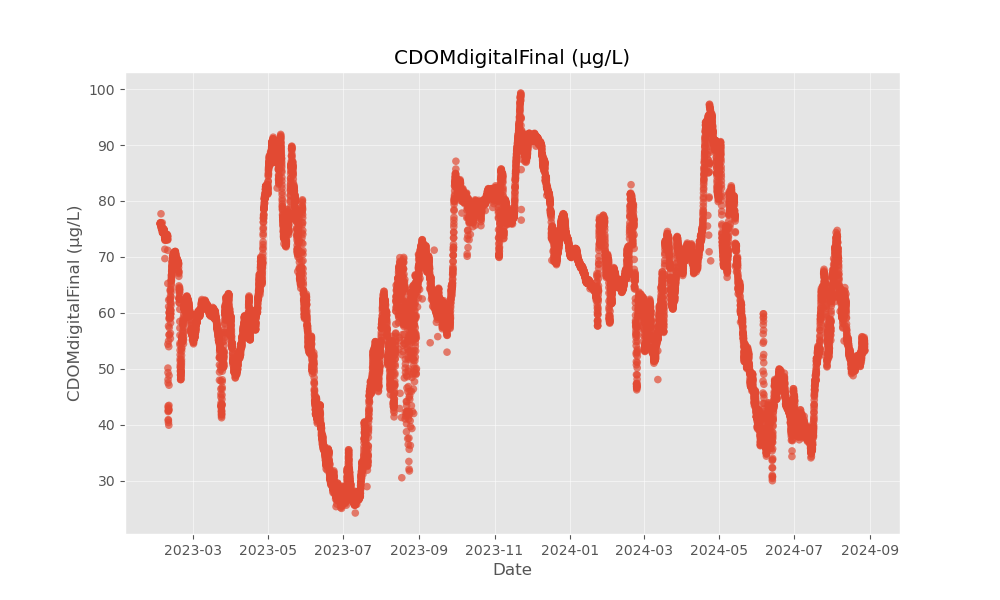

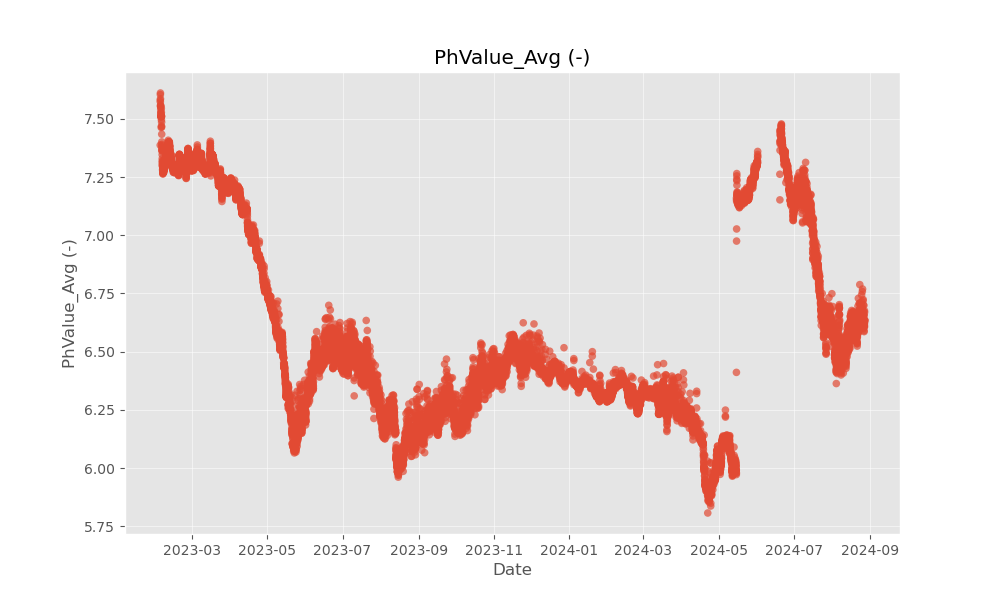

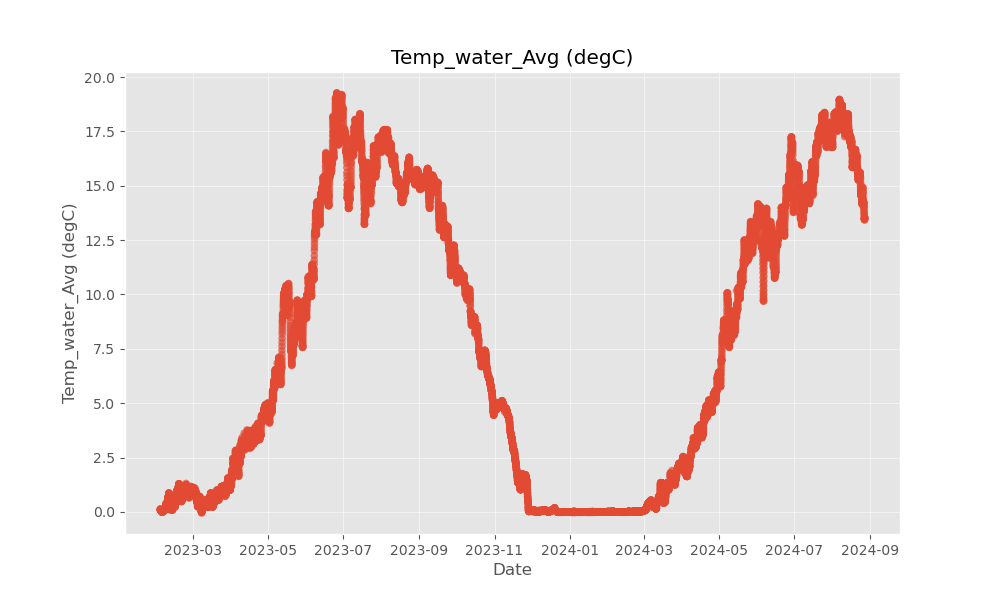

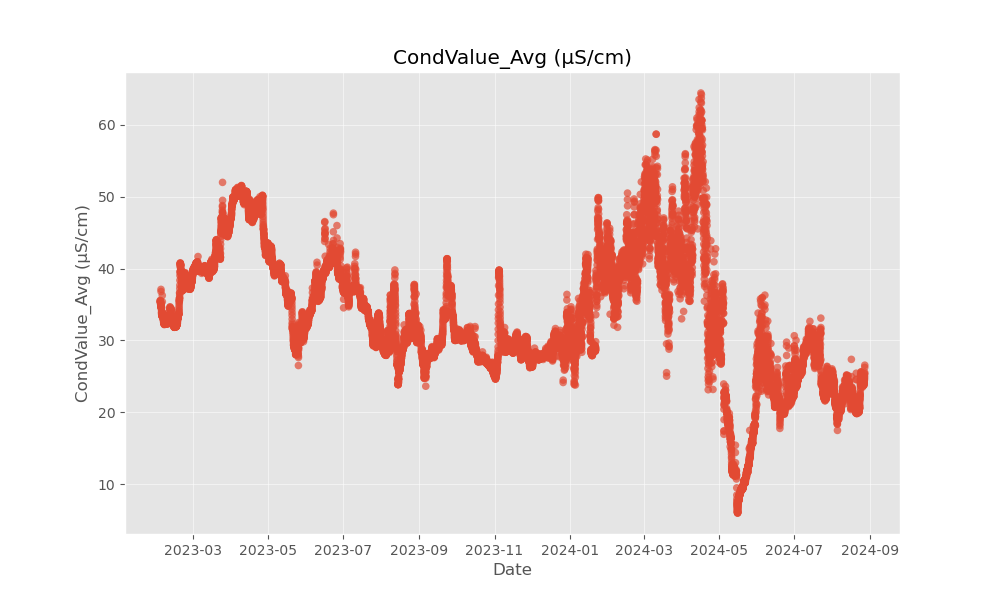

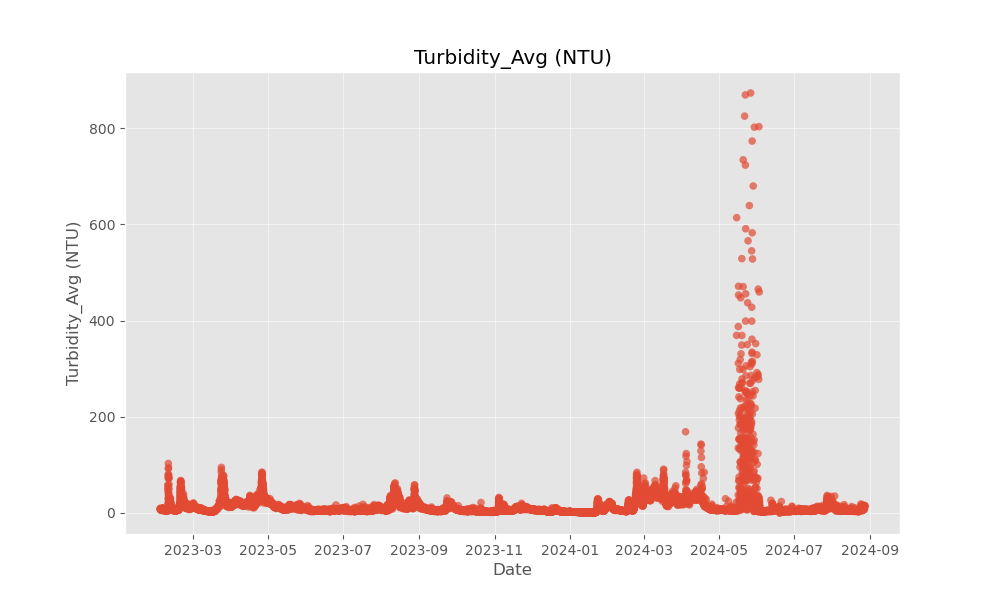

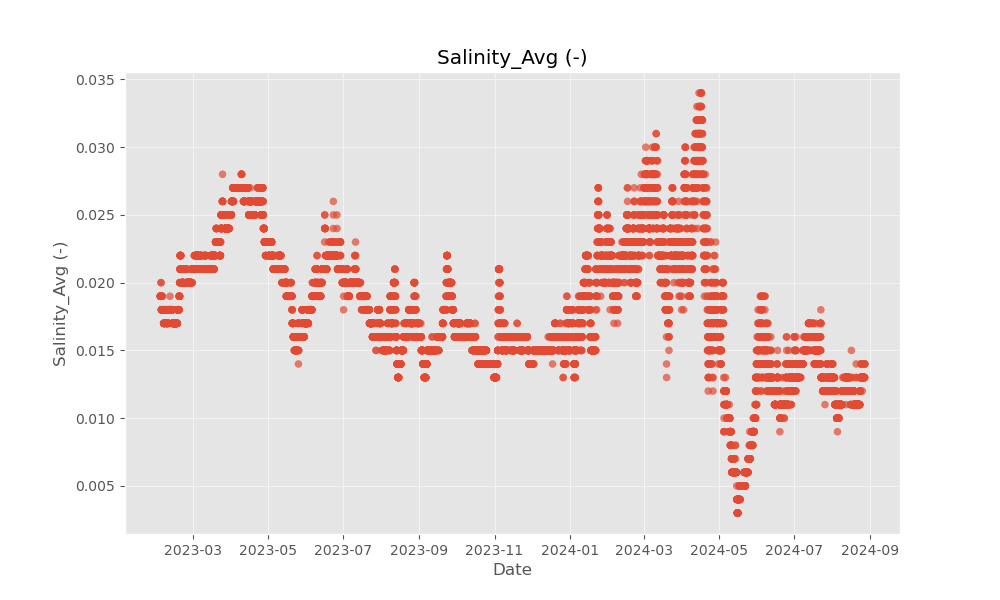

In [8]:
# Plot variables without outliers
for variable in variables:
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[variable], edgecolors='none', alpha=0.7, s=30)
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.title(f'{variable}')
    plt.grid(True, alpha =0.5)
    plt.show()


### 6. Read the discharge data and select the data from the same time period as the sensor data

In [9]:
q_df = pd.read_csv(qfpath)

# Convert 'Date' column to datetime if it's not already
q_df['Date'] = pd.to_datetime(q_df['Date'])

# Define start and end dates
start_date = '2023-02-02'
end_date = '2024-08-27'

# Filter DataFrame
q_df = q_df[(q_df['Date'] >= start_date) & (q_df['Date'] <= end_date)]
q_df

Date  Discharge
12085 2023-02-02    525.875
12086 2023-02-03    501.271
12087 2023-02-04    500.396
12088 2023-02-05    501.896
12089 2023-02-06    500.875
...          ...        ...
12653 2024-08-23   1045.979
12654 2024-08-24   1219.458
12655 2024-08-25   1404.875
12656 2024-08-26   1608.979
12657 2024-08-27   1718.854

[573 rows x 2 columns]

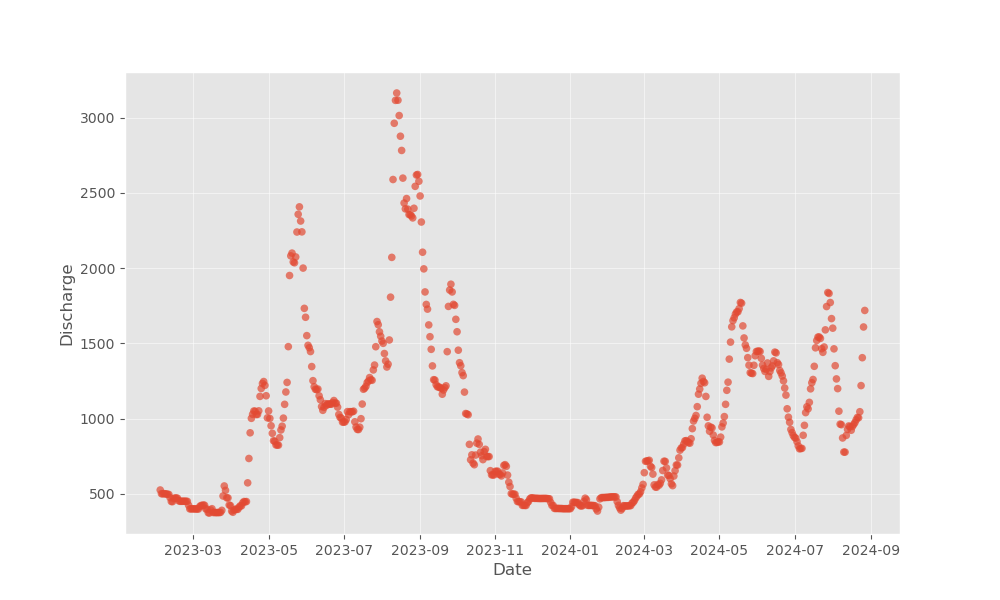

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(q_df['Date'], q_df['Discharge'], edgecolors='none', alpha=0.7, s=30)
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.grid(True, alpha =0.5)
plt.show()

**Note:** Based on discharges, I would expect substantial changes in the parameters in 09/2023, which are not observed here. However, there is a drop in salinity and conductivity, and a peak in turbidity in 05/2024. During that period, discharges show a local peak, though it is lower compared to those in 05/2023 and 08/2023.

I have asked Ivana if the abrupt change in salinity and turbidity in May 2024 could indicate an issue with the sensor rather than an actual event. She will ask Uta. If needed I will drop those observations.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


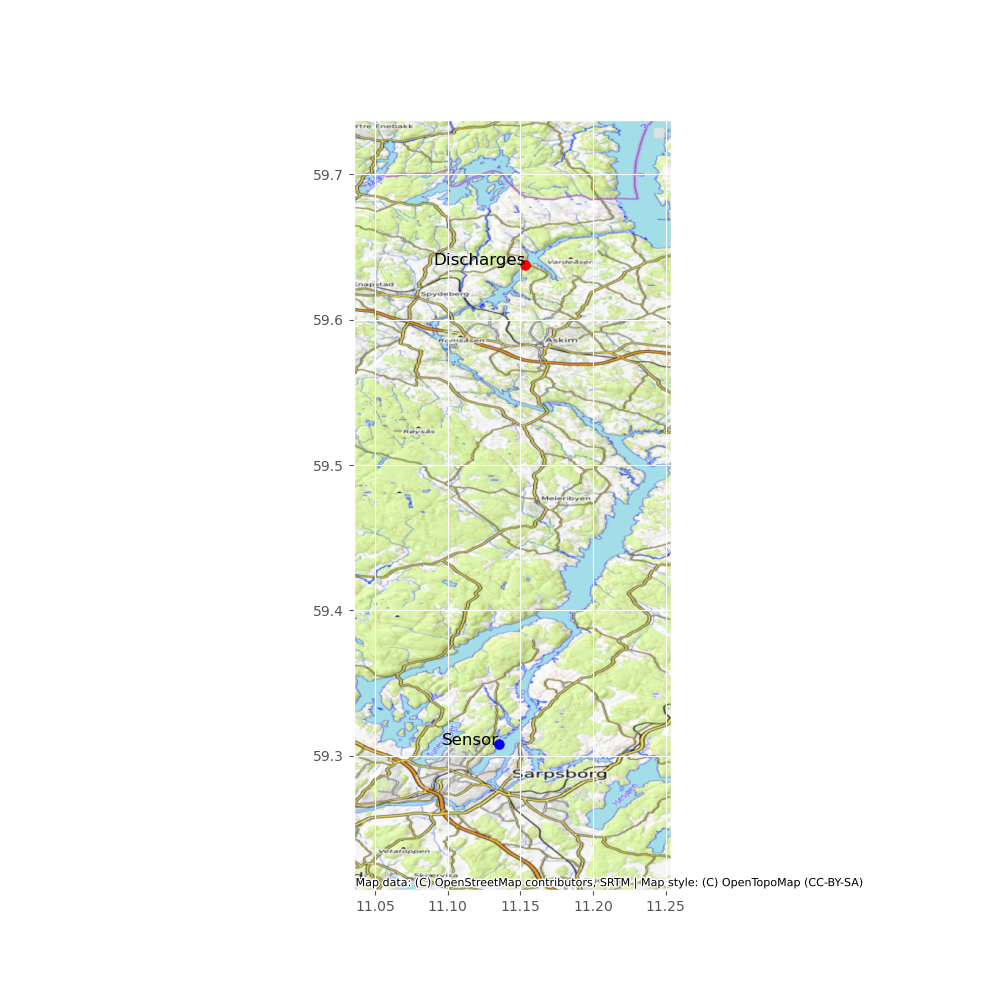

In [11]:
# Coordinates for the two points
glat, glon = 59.63733, 11.15354
slat, slon = 59.30778, 11.1355

# Create GeoDataFrame for the two points
points = [Point(glon, glat), Point(slon, slat)]
df_sl = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

# Plot the points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
df_sl.plot(ax=ax, markersize=50, color=['red', 'blue'])

# Add text annotations
ax.text(glon, glat, 'Discharges', fontsize=12, ha='right')
ax.text(slon, slat, 'Sensor', fontsize=12, ha='right')

# Set the extent to display a larger area
buffer = 0.1  # Adjust this value to show more or less of the map
minx, miny, maxx, maxy = df_sl.total_bounds
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

# Add basemap
cx.add_basemap(ax, crs=df_sl.crs, source=cx.providers.OpenTopoMap)

plt.legend()
plt.show()

**Note:** Could the difference in sampling locations of discharges and sensor data explain the mismatch?

### 7. Check if the timestep is consistent

In [12]:
# Convert 'Date' to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Define the complete date range
start_date = '2023-02-02'
end_date = '2024-08-27'
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Find missing dates
present_dates = df['Date'].dt.date.unique()
missing_dates = set(complete_date_range.date) - set(present_dates)

# Print missing dates
if missing_dates:
    print(f"Missing dates: {sorted(missing_dates)}")
else:
    print("No missing dates.")

No missing dates.


In [13]:
expected_hours = [
    '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00',
    '20:00:00', '21:00:00', '22:00:00', '23:00:00', '00:00:00',
    '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
    '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00',
    '11:00:00', '12:00:00', '13:00:00', '14:00:00'
]

# Find missing hours for each date
missing_hours_by_date = {}
for date, group in df.groupby('Date'):
    missing_hours = set(expected_hours) - set(group['Time'])
    if missing_hours:
        missing_hours_by_date[date] = missing_hours

# Print dates with missing hours
for date, missing_hours in missing_hours_by_date.items():
    print(f"Date: {date}, Missing hours: {sorted(missing_hours)}")

Date: 2023-02-02 00:00:00, Missing hours: ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00']
Date: 2024-08-27 00:00:00, Missing hours: ['13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']


**Note:** There is a consistent timestep in the dataframe, so I can proceed with linear interpolation to fill the missing values.

### 8. Linear interpolation
There is a 19 days gap in PH, so I will not apply linear interpolation for those.

In [14]:
# Define the date range to exclude
exclude_start = '2024-06-01'
exclude_end = '2024-06-19'

# Mask for the dates to exclude
mask = (df.index < exclude_start) | (df.index > exclude_end)

# Interpolate the PH variable excluding the specified date range
df.loc[mask, 'PhValue_Avg (-)'] = df.loc[mask, 'PhValue_Avg (-)'].interpolate(method='linear')

# Interpolate the remaining variables normally
for variable in variables_exc_ph:
    df[variable].interpolate(method='linear', inplace=True)

df

/tmp/ipykernel_5108/3988324710.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[variable].interpolate(method='linear', inplace=True)


Date      Time  CDOMdigitalFinal (µg/L)  \
Datetime                                                            
2023-02-02 15:00:00 2023-02-02  15:00:00                    76.04   
2023-02-02 16:00:00 2023-02-02  16:00:00                    76.01   
2023-02-02 17:00:00 2023-02-02  17:00:00                    75.91   
2023-02-02 18:00:00 2023-02-02  18:00:00                    75.84   
2023-02-02 19:00:00 2023-02-02  19:00:00                    75.83   
...                        ...       ...                      ...   
2024-08-27 08:00:00 2024-08-27  08:00:00                    54.54   
2024-08-27 09:00:00 2024-08-27  09:00:00                    53.84   
2024-08-27 10:00:00 2024-08-27  10:00:00                    53.37   
2024-08-27 11:00:00 2024-08-27  11:00:00                    53.27   
2024-08-27 12:00:00 2024-08-27  12:00:00                    53.18   

                    QC flag CDOMdigitalFinal  PhValue_Avg (-)  \
Datetime                                                        
2023-02-02 15:00:00                      NaN              NaN   
2023-02-02 16:00:00                      NaN              NaN   
2023-02-02 17:00:00                      NaN              NaN   
2023-02-02 18:00:00                      NaN              NaN   
2023-02-02 19:00:00                     Good              NaN   
...                                      ...              ...   
2024-08-27 08:00:00                     Good            6.669   
2024-08-27 09:00:00                     Good            6.635   
2024-08-27 10:00:00                      NaN            6.626   
2024-08-27 11:00:00                      NaN            6.636   
2024-08-27 12:00:00                      NaN            6.635   

                    QC flag PhValue_Avg  Temp_water_Avg (degC)  \
Datetime                                                         
2023-02-02 15:00:00                 NaN                  0.103   
2023-02-02 16:00:00                 NaN                  0.121   
2023-02-02 17:00:00                 NaN                  0.130   
2023-02-02 18:00:00                 NaN                  0.121   
2023-02-02 19:00:00                Good                  0.090   
...                                 ...                    ...   
2024-08-27 08:00:00                Good                 13.470   
2024-08-27 09:00:00                Good                 13.480   
2024-08-27 10:00:00                 NaN                 13.490   
2024-08-27 11:00:00                 NaN                 13.540   
2024-08-27 12:00:00                 NaN                 13.540   

                    QC flag Temp_water_Avg  CondValue_Avg (µS/cm)  \
Datetime                                                            
2023-02-02 15:00:00                    NaN                  35.52   
2023-02-02 16:00:00                    NaN                  35.56   
2023-02-02 17:00:00                    NaN                  35.47   
2023-02-02 18:00:00                    NaN                  35.35   
2023-02-02 19:00:00                   Good                  35.30   
...                                    ...                    ...   
2024-08-27 08:00:00                   Good                  25.36   
2024-08-27 09:00:00                   Good                  25.32   
2024-08-27 10:00:00                    NaN                  25.55   
2024-08-27 11:00:00                    NaN                  26.24   
2024-08-27 12:00:00                    NaN                  26.55   

                    QC flag CondValue_Avg  ...  Salinity_Avg (-)  \
Datetime                                   ...                     
2023-02-02 15:00:00                   NaN  ...             0.019   
2023-02-02 16:00:00                   NaN  ...             0.019   
2023-02-02 17:00:00                   NaN  ...             0.019   
2023-02-02 18:00:00                   NaN  ...             0.019   
2023-02-02 19:00:00                  Good  ...             0.019   
...                                   ...  ...   

/tmp/ipykernel_5108/537272714.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))


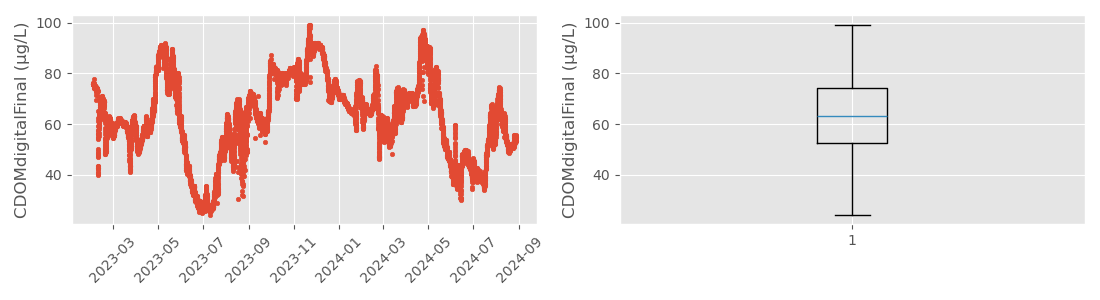

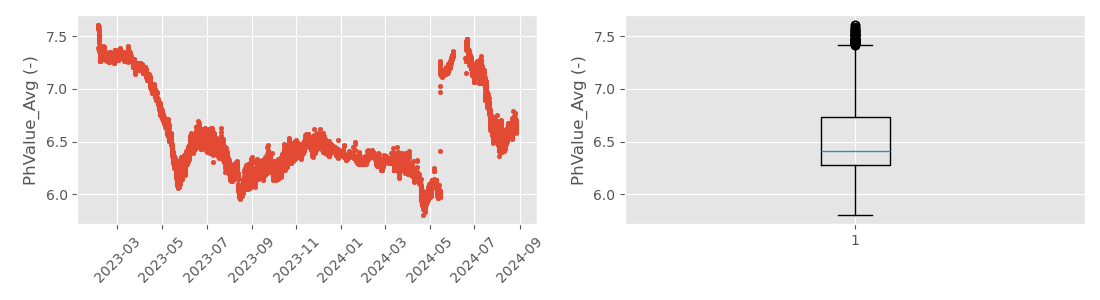

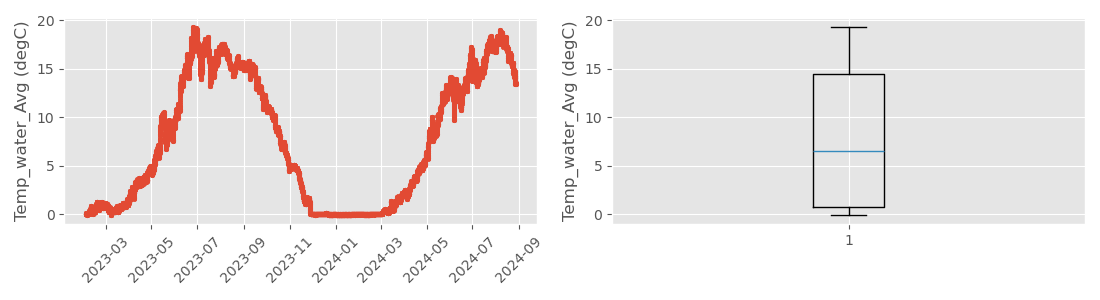

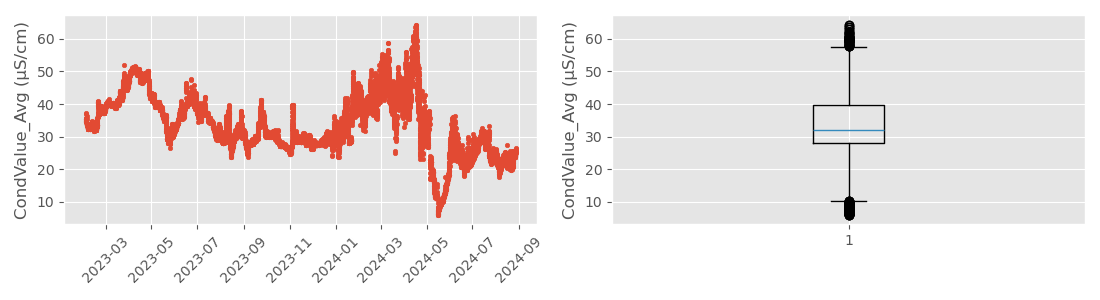

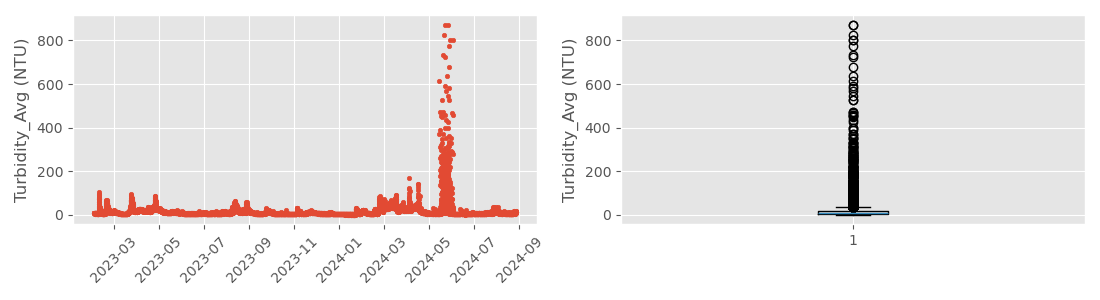

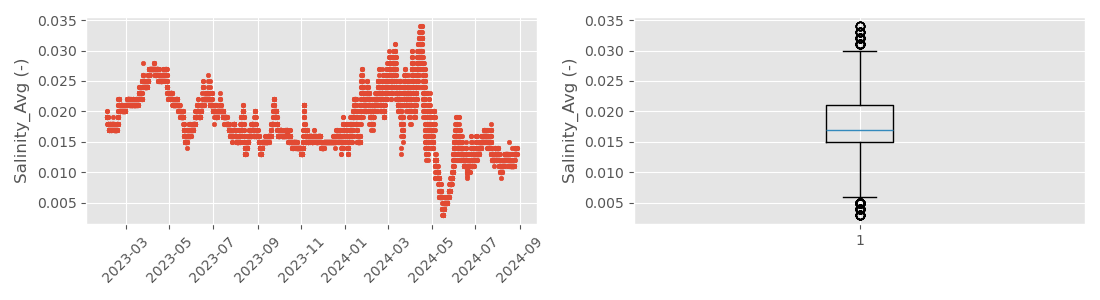

In [15]:
for var in variables:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

    # Scatter plot
    ax1.scatter(df.index, df[var], s=10)
    ax1.set_ylabel(var)
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Boxplot
    ax2.boxplot(df[var].dropna())
    ax2.set_ylabel(var)

    plt.tight_layout()
    plt.show()

In [16]:
# Drop unnecessary columns 
df = df.drop(columns=columns_to_drop)

# Save cleaned high frequent data
df.to_csv(out_path_hourly, index = False)

df.head()

Date      Time  CDOMdigitalFinal (µg/L)  \
Datetime                                                            
2023-02-02 15:00:00 2023-02-02  15:00:00                    76.04   
2023-02-02 16:00:00 2023-02-02  16:00:00                    76.01   
2023-02-02 17:00:00 2023-02-02  17:00:00                    75.91   
2023-02-02 18:00:00 2023-02-02  18:00:00                    75.84   
2023-02-02 19:00:00 2023-02-02  19:00:00                    75.83   

                     PhValue_Avg (-)  Temp_water_Avg (degC)  \
Datetime                                                      
2023-02-02 15:00:00              NaN                  0.103   
2023-02-02 16:00:00              NaN                  0.121   
2023-02-02 17:00:00              NaN                  0.130   
2023-02-02 18:00:00              NaN                  0.121   
2023-02-02 19:00:00              NaN                  0.090   

                     CondValue_Avg (µS/cm)  Turbidity_Avg (NTU)  \
Datetime                                                          
2023-02-02 15:00:00                  35.52                9.060   
2023-02-02 16:00:00                  35.56                8.070   
2023-02-02 17:00:00                  35.47                8.570   
2023-02-02 18:00:00                  35.35                8.580   
2023-02-02 19:00:00                  35.30                7.268   

                     Salinity_Avg (-)  
Datetime                               
2023-02-02 15:00:00             0.019  
2023-02-02 16:00:00             0.019  
2023-02-02 17:00:00             0.019  
2023-02-02 18:00:00             0.019  
2023-02-02 19:00:00             0.019

### 9. Daily averages

In [17]:
# Compute medians 
median_df = df.groupby(['Date'])[variables].median().reset_index()

# Compute means
mean_df = df.groupby(['Date'])[variables].mean().reset_index()

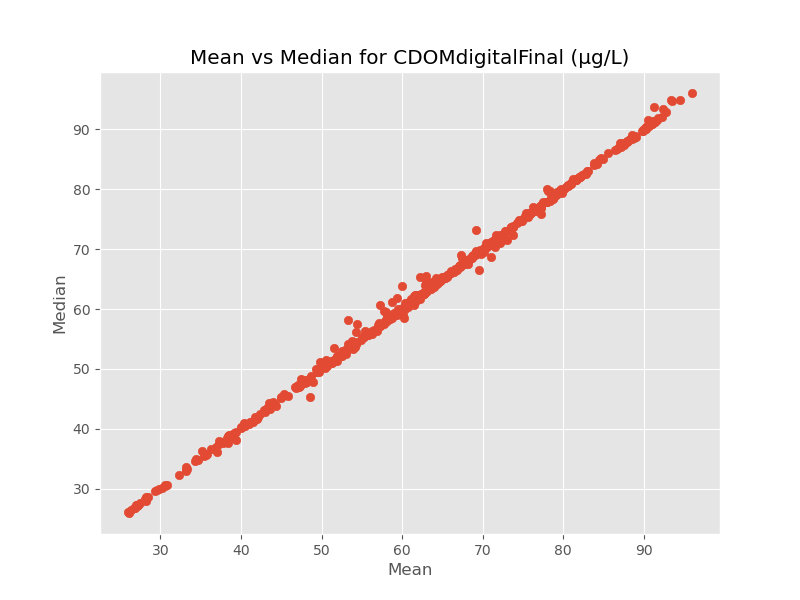

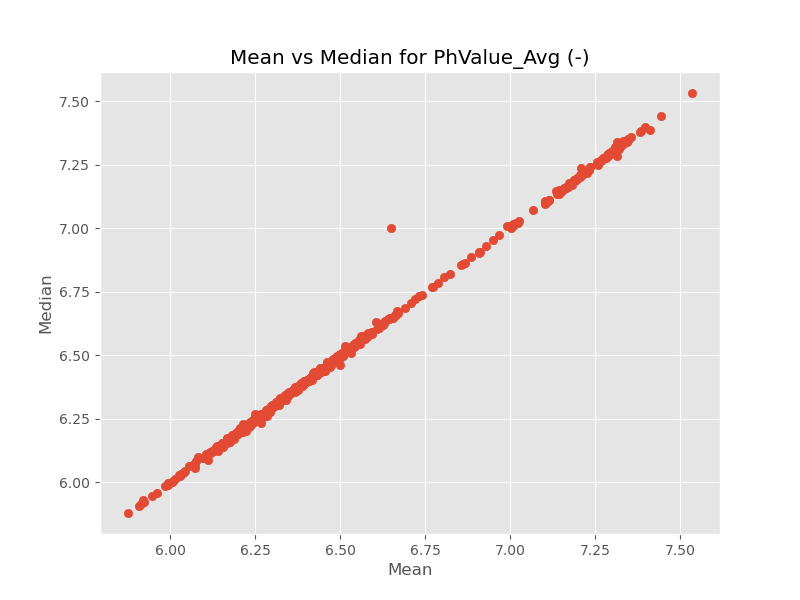

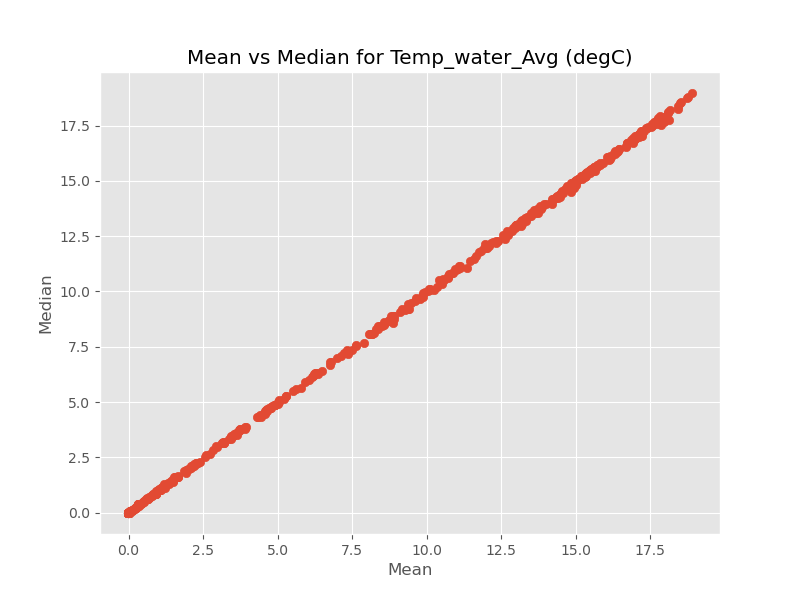

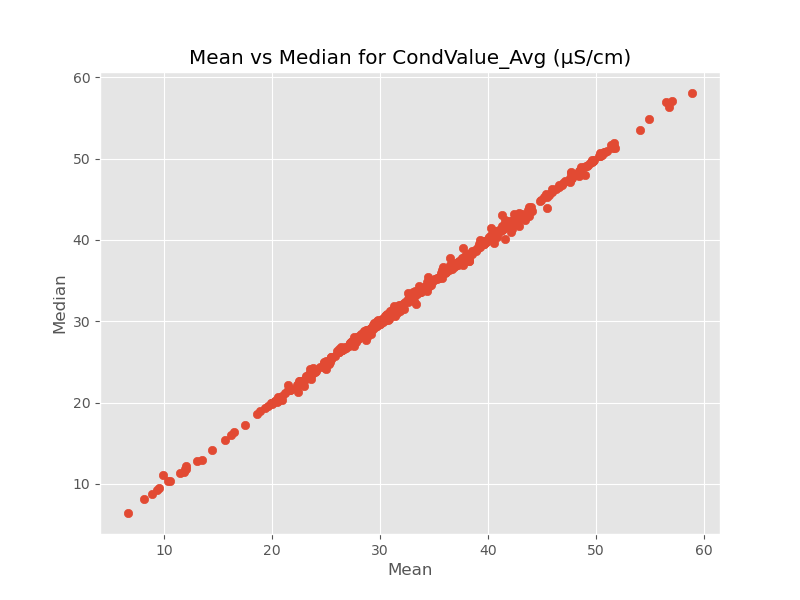

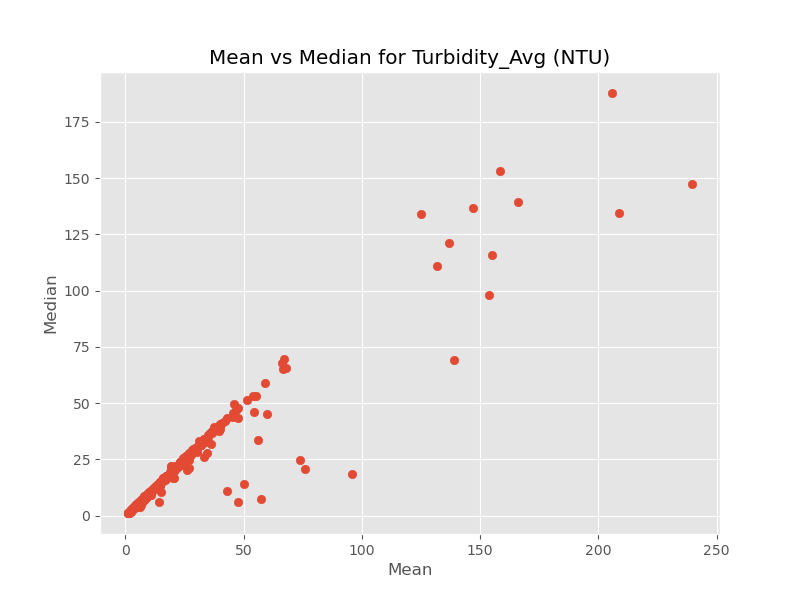

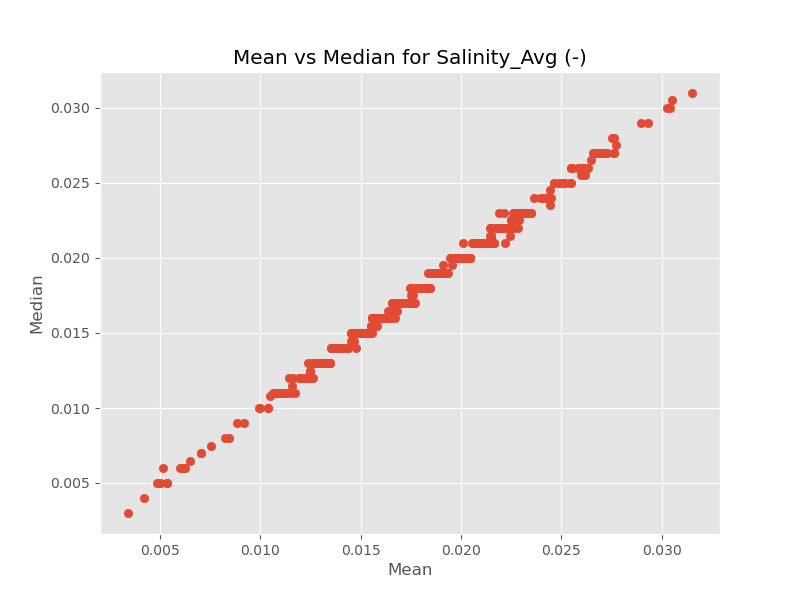

In [18]:
for var in variables:
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_df[var], median_df[var])
    plt.title(f'Mean vs Median for {var}')
    plt.xlabel('Mean')
    plt.ylabel('Median')
    plt.grid(True)
    plt.show()

**Note:** Both daily medians and means seem to be similar, except for turbidity, where the arithmetic mean is much higher than the medians. Therefore, I will save the daily medians for future analysis. 

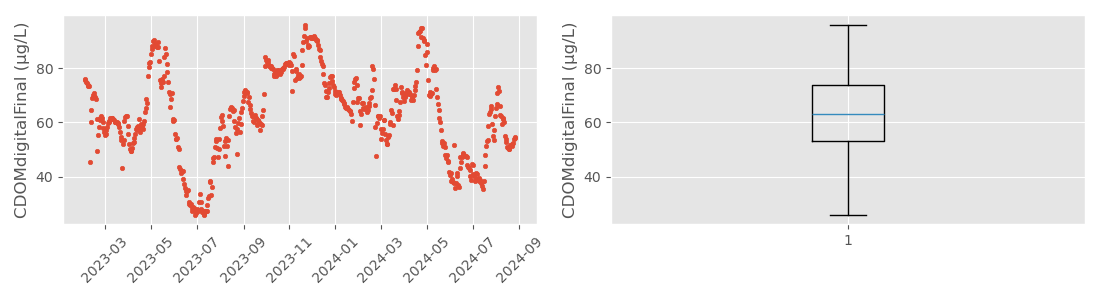

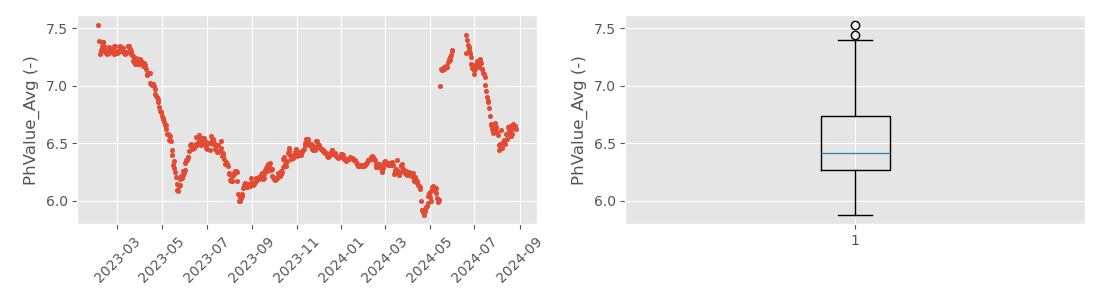

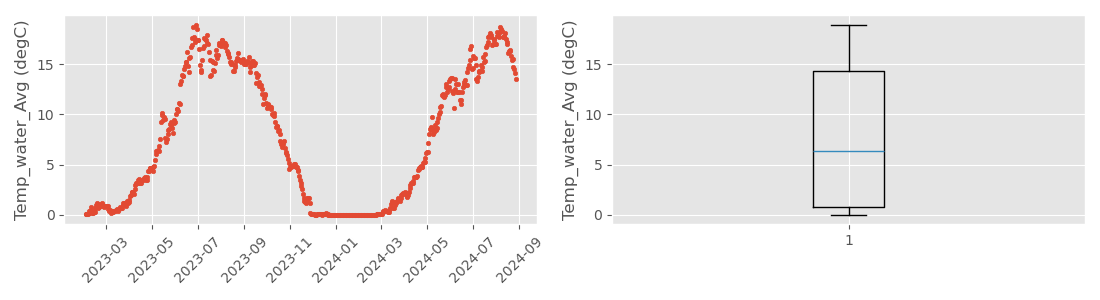

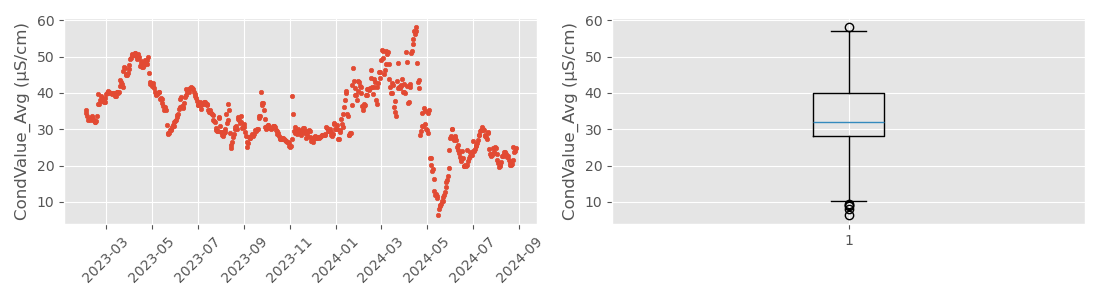

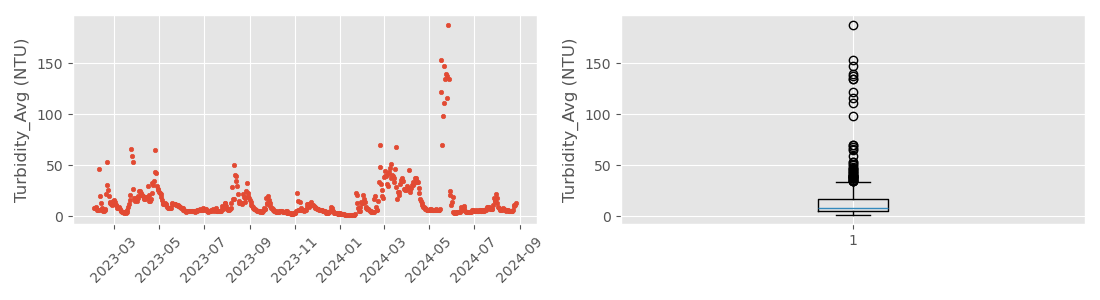

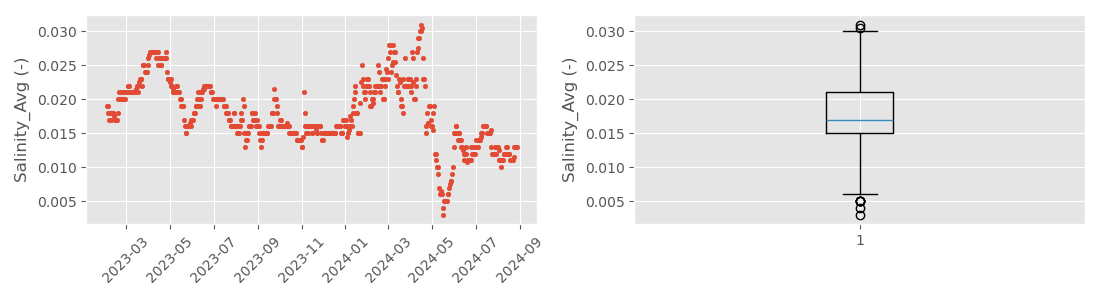

In [19]:
for var in variables:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

    # Scatter plot
    ax1.scatter(median_df['Date'], median_df[var], s=10)
    ax1.set_ylabel(var)
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Boxplot
    ax2.boxplot(median_df[var].dropna()) # PH has some missing values
    ax2.set_ylabel(var)

    plt.tight_layout()
    plt.show()

In [20]:
# Daily means and save
median_df.to_csv(out_path_daily)
median_df.head()

Date  CDOMdigitalFinal (µg/L)  PhValue_Avg (-)  Temp_water_Avg (degC)  \
0 2023-02-02                   76.000              NaN                 0.0900   
1 2023-02-03                   75.430           7.5330                 0.0595   
2 2023-02-04                   74.765           7.3875                 0.0300   
3 2023-02-05                   74.645           7.2770                 0.0635   
4 2023-02-06                   73.385           7.2950                 0.1325   

   CondValue_Avg (µS/cm)  Turbidity_Avg (NTU)  Salinity_Avg (-)  
0                 35.350               8.1700             0.019  
1                 34.580               8.1200             0.019  
2                 33.615               8.8900             0.018  
3                 32.585               7.8885             0.017  
4                 32.685               6.1120             0.018

### 10. Compare daily sensor data with discharges

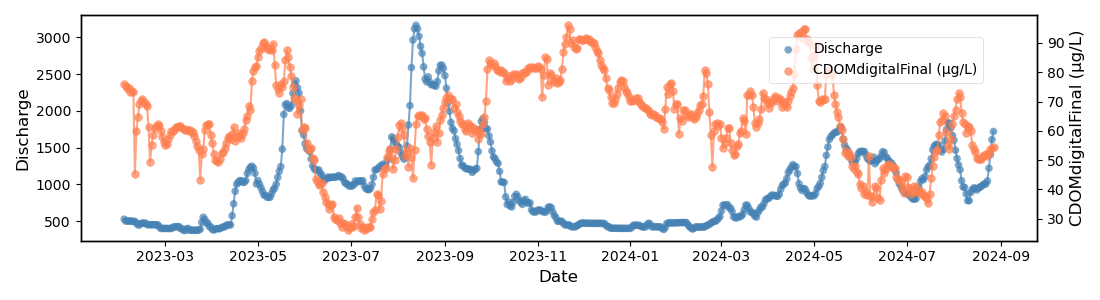

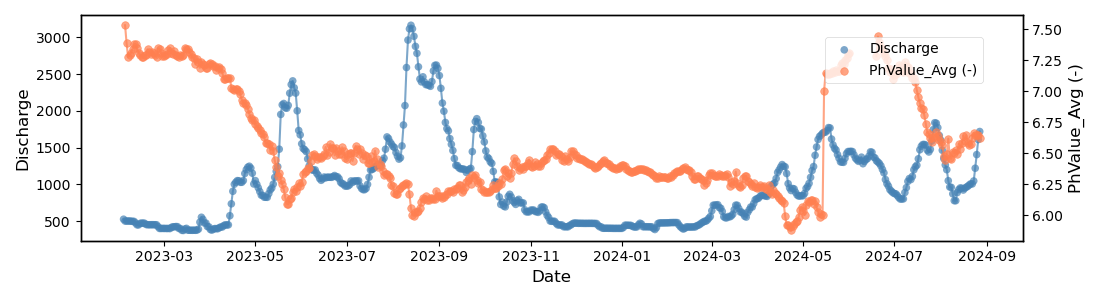

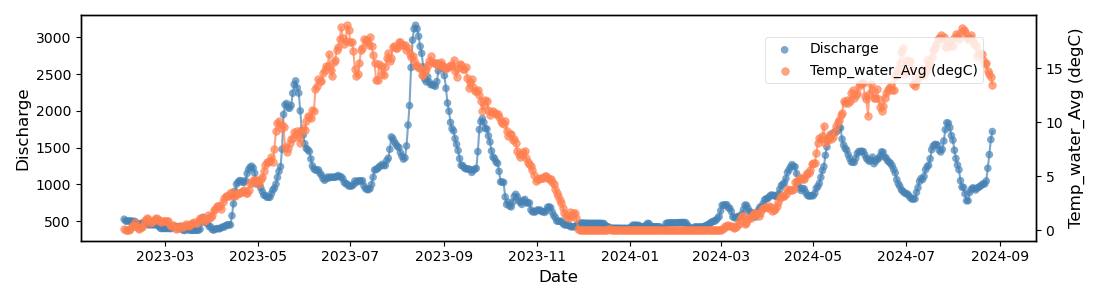

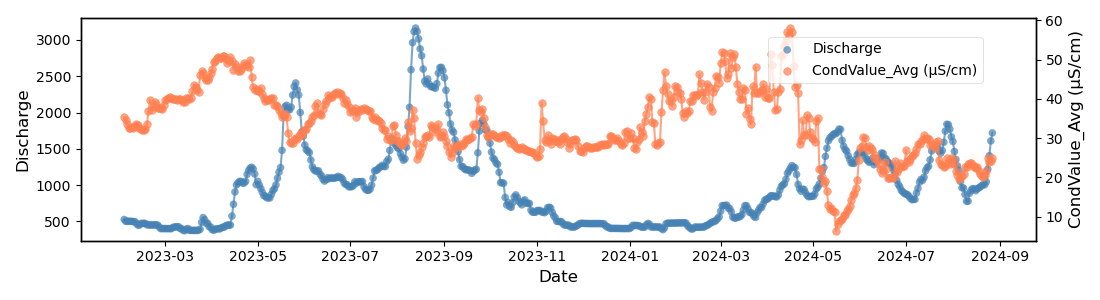

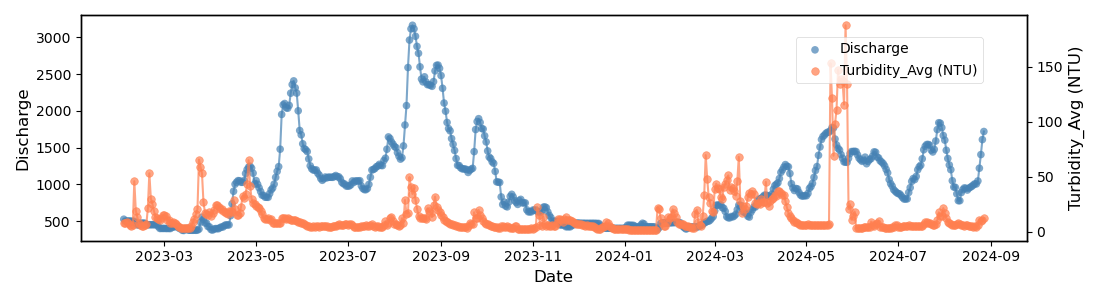

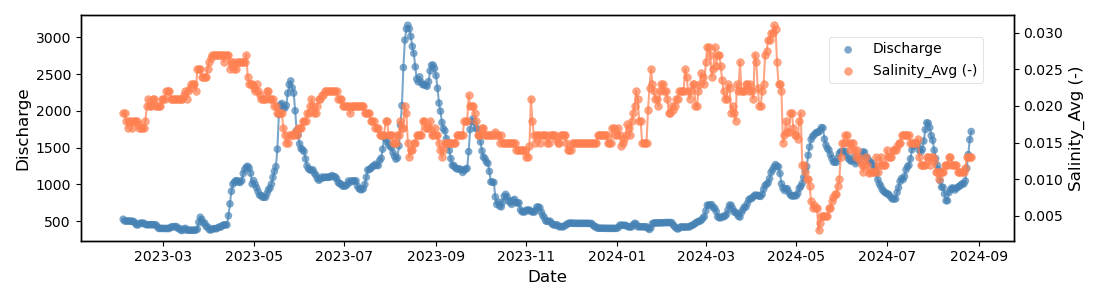

In [42]:
# Plot discharge and sensor variables as time series
for var in variables:
    fig, ax1 = plt.subplots(figsize=(11, 3))

    # Plot discharge
    scatter1 = ax1.scatter(q_df['Date'], q_df['Discharge'], edgecolors='none', alpha=0.7, s=30, label='Discharge', color='steelblue')
    line1 = ax1.plot(q_df['Date'], q_df['Discharge'], alpha=0.7, color='steelblue')  # Add line for discharge
    ax1.set_xlabel('Date', color='black')
    ax1.set_ylabel('Discharge', color='black')
    ax1.tick_params(axis='x', colors='black')
    ax1.tick_params(axis='y', colors='black')
    ax1.spines['top'].set_color('black')
    ax1.spines['bottom'].set_color('black')
    ax1.spines['left'].set_color('black')
    ax1.spines['right'].set_color('black')
    ax1.grid(False)  # Disable grid lines for ax1

    # Plot sensor variable 
    ax2 = ax1.twinx()
    scatter2 = ax2.scatter(median_df['Date'], median_df[var], s=30, alpha=0.7, color='coral', label=var)
    line2 = ax2.plot(median_df['Date'], median_df[var], alpha=0.7, color='coral')  # Add line for sensor variable
    ax2.set_ylabel(var, color='black')
    ax2.tick_params(axis='y', colors='black')
    ax2.spines['top'].set_color('black')
    ax2.spines['bottom'].set_color('black')
    ax2.spines['left'].set_color('black')
    ax2.spines['right'].set_color('black')
    ax2.grid(False)  # Disable grid lines for ax2
    
    # Set background color to transparent
    fig.patch.set_facecolor('none')
    ax1.set_facecolor('none')
    ax2.set_facecolor('none')

    # Legend
    legend =  fig.legend(handles=[scatter1, scatter2], labels=['Discharge', var], loc='upper right', bbox_to_anchor=(0.9, 0.9))
    legend.get_frame().set_facecolor('white')

    fig.tight_layout()
    plt.show()
